In [80]:
import numpy, pandas, pathlib

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from skops.io import load

from misc import construct_line

pandas.options.display.max_columns=100

pathlib.Path('pdf/figure-3').mkdir(exist_ok=True)

In [81]:
best_model = {}
X={}
Y={}
Z={}
very_major_errors = {}
major_errors = {}

In [82]:
for model in ['LR', 'NN', 'XB']:
    best_model[model] = load('models/'+model.lower()+'.skops', trusted=True)

# load the training dataset

X['train']={}
Y['train']={}
Z['train']={}
with open('data/ds-train.npy', 'rb') as f:
    Y['train']['input'] = numpy.load(f)
    X['train']['input'] = numpy.load(f)
    Z['train']['input'] = numpy.load(f, allow_pickle=True)

# load the results for the training dataset
results = pandas.read_csv('results-training.csv')
results

,model,dataset,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,roc_auc_mean,roc_auc_std,TN,FP,FN,TP,model_parameters,diagnostic_odds_ratio_mean,diagnostic_odds_ratio_std
0,LR,train,78.800000,6.200717,84.357576,5.114400,82.484060,7.276335,180,38,49,197,"{""C"": 1.0, ""penalty"": ""l1"", ""solver"": ""libline...",19.044039,0
1,NN,train,78.916667,5.147950,83.682792,5.282488,81.760028,7.781499,218,0,0,246,"{""activation"": ""logistic"", ""alpha"": 0.01, ""hid...",inf,0
2,XB,train,79.216667,5.468115,85.781926,4.776355,83.502833,7.880220,192,26,43,203,"{""learning_rate"": 0.05, ""max_depth"": 4, ""min_c...",34.862254,0
3,SP,train,97.967480,NaN,95.412844,NaN,NaN,NaN,208,10,5,241,NaN,1002.560000,0


In [83]:
for metric in ['sensitivity', 'specificity', 'roc_auc', 'diagnostic_odds_ratio']:
    colour='#888888'
    fig = plt.figure(figsize=(2.2, 3.5))
    axes = plt.gca()
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.get_yaxis().set_visible(False)
    x=range(4)
    x=results[(results.model!='SP')].model
    y=results[(results.model!='SP')][metric+'_mean']
    e=results[(results.model!='SP')][metric+'_std']
    axes.set_ylim([0,100])
    axes.bar(x,y, label=y, edgecolor=colour, color='None',linewidth=2)

    if e.sum()>0:
        axes.errorbar(x,y,yerr=e, fmt='.',color=colour,linewidth=2)
        for (i,j,k) in zip(x,y,e):
            axes.text(i,j+k+2,'%.1f' % j,ha='center',color=colour)

    else:
        for (i,j) in zip(x,y):
            axes.text(i,j+2,'%.1f' % j,ha='center',color=colour)

    fig.savefig('pdf/figure-3/fig-3-train-'+metric+'.pdf', bbox_inches="tight")
    plt.close()

posx and posy should be finite values
posx and posy should be finite values


In [84]:
for metric in ['sensitivity', 'specificity']:
    colour=['#888888','#888888','#888888','pink']
    fig = plt.figure(figsize=(3.2, 3.5))
    axes = plt.gca()
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.get_yaxis().set_visible(False)
    x=results.model
    y=results[metric+'_mean']
    e=results[metric+'_std']
    axes.set_ylim([0,100])
    axes.bar(x,y, label=y, edgecolor=colour, color='None',linewidth=2)

    if e.sum()>0:
        axes.errorbar(x,y,yerr=e, fmt='.',color='#888888',linewidth=2)
        for (i,j,k,c) in zip(x,y,e,colour):
            if k>0:
                axes.text(i,j+k+2,'%.1f' % j,ha='center',color=c)
            else:
                axes.text(i,j+2,'%.1f' % j,ha='center',color=c)

    else:
        for (i,j,c) in zip(x,y,colour):                
            axes.text(i,j+2,'%.1f' % j,ha='center',color=c)

    fig.savefig('pdf/figure-3/fig-3-train-'+metric+'-suspectpza.pdf', bbox_inches="tight")
    plt.close()

In [85]:
for idx,row in results.iterrows():

    fig = plt.figure(figsize=(1.5, 1.5))
    axes = plt.gca()

    axes.add_patch(Rectangle((0,0),1,1,fc='#e41a1c',alpha=0.7))
    axes.add_patch(Rectangle((0,1),1,1,fc='#4daf4a',alpha=0.7))
    axes.add_patch(Rectangle((1,1),1,1,fc='#fc9272',alpha=0.7))
    axes.add_patch(Rectangle((1,0),1,1,fc='#4daf4a',alpha=0.7))

    axes.set_xlim([0,2])
    axes.set_ylim([0,2])

    axes.set_xticks([0.5,1.5],labels=['R','S'])
    axes.set_yticks([0.5,1.5],labels=['S','R'])

    axes.text(0.5,0.5,row['FN'],ha='center',va='center')
    axes.text(1.5,0.5,row['TN'],ha='center',va='center')
    axes.text(0.5,1.5,row['TP'],ha='center',va='center')
    axes.text(1.5,1.5,row['FP'],ha='center',va='center')

    fig.savefig('pdf/figure-3/truthtable-'+row['dataset']+'-'+row['model']+'.pdf', bbox_inches='tight')
    plt.close()

### Model validation on `test` set

We can now evaluate the trained models on the `test` dataset.

First let's load the trained models, the datasets and the results for Suspect-PZA


In [86]:
for model in ['LR', 'NN', 'XB']:
    best_model[model] = load('models/'+model.lower()+'.skops', trusted=True)

# load the test dataset
X['test']={}
Y['test']={}
Z['test']={}
with open('data/ds-test.npy', 'rb') as f:
    Y['test']['input'] = numpy.load(f)
    X['test']['input'] = numpy.load(f)
    Z['test']['input'] = numpy.load(f, allow_pickle=True)

# load in the results for SuspectPZA
suspectpza={}
for i in ['test']:
    suspectpza[i]={}
    with open('data/suspectpza-'+i+'.npy', 'rb') as f:
        suspectpza[i]['input'] = numpy.load(f)
        suspectpza[i]['predicted'] = numpy.load(f)
        suspectpza[i]['muts'] = numpy.load(f, allow_pickle=True)
line = []

def validate_model(line, best_model, model_name, X, Y):
        
    Y['test']['predicted'] = best_model.predict(X['test']['input'])
    Y['test']['scores'] = best_model.predict_proba(X['test']['input'])[:,1]
    row = construct_line(model_name , 'test', None, Y['test'], None)
    line.append(row)
    return(line)

for model in ['LR', 'NN', 'XB']:
    line = validate_model(line, best_model[model], model, X, Y)

line.append(construct_line('SP', 'test', None, suspectpza['test'], None))

# load the results for the training dataset
# results = pandas.read_csv('results-training.csv')
# results

In [33]:
Y['test']['scores']

array([0.3422877 , 0.675213  , 0.95866615, 0.6745226 , 0.96927077,
       0.29698324, 0.8893544 , 0.10186646, 0.76240206, 0.9237728 ,
       0.9379925 , 0.93253255, 0.9386976 , 0.6811158 , 0.7281425 ,
       0.18223076, 0.861866  , 0.7112937 , 0.7689196 , 0.6672928 ,
       0.6225203 , 0.9691112 , 0.29215786, 0.37513733, 0.92707473,
       0.7551507 , 0.9660066 , 0.80092615, 0.90908605, 0.63447225,
       0.56226385, 0.11596642, 0.18576673, 0.26475826, 0.32808548,
       0.9483859 , 0.49672604, 0.5883981 , 0.3410981 , 0.32850564,
       0.22821176, 0.87422514, 0.96947587, 0.89493895, 0.61474097,
       0.76225203, 0.29872456, 0.34208894, 0.95087945, 0.2554938 ,
       0.46356848, 0.97079986, 0.36068758, 0.21041678, 0.18247513,
       0.21920893, 0.9471151 , 0.27067345, 0.7850704 , 0.18505482,
       0.7318302 , 0.63263315, 0.49634966, 0.5926549 , 0.12072977,
       0.29594493, 0.12549098, 0.52180225, 0.24772516, 0.18001458,
       0.96066415, 0.9170291 , 0.3580864 , 0.6185208 , 0.68174

In [34]:
from sklearn.utils import resample

In [35]:
resample(X['test']['input'], Y['test']['input'])

[array([[-0.06      ,  0.27008547,  0.84871042, ...,  0.08      ,
          0.25565256, -0.22365691],
        [-0.5       ,  0.63760684,  0.73711145, ...,  0.04173913,
         -0.45175733, -0.26792714],
        [ 0.1       ,  0.27008547, -0.10648135, ..., -0.06782609,
          0.156257  , -0.20797786],
        ...,
        [ 0.64      , -0.92364672,  0.64005118, ...,  0.65391304,
          0.56637564, -0.15264007],
        [ 0.22      ,  0.97378917,  0.74961472, ...,  0.05043478,
         -0.85023506,  0.00230574],
        [ 0.1       ,  0.96809117,  0.66348754, ..., -0.28869565,
         -0.74009402,  0.16186304]]),
 array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
   

In [36]:
X['test']['input'].shape

(200, 16)

In [87]:
test_results = pandas.DataFrame(line, columns=['model', 'dataset', 'sensitivity_mean', 'sensitivity_std', 'specificity_mean', 'specificity_std' ,'roc_auc_mean', 'roc_auc_std','TN','FP','FN','TP', 'model_parameters'])
test_results['diagnostic_odds_ratio_mean'] = (test_results['TN']*test_results['TP'])/(test_results['FN']*test_results['FP'])
test_results['diagnostic_odds_ratio_std'] = 0
test_results.to_csv('results-test.csv', index=False)
test_results

,model,dataset,sensitivity_mean,sensitivity_std,specificity_mean,specificity_std,roc_auc_mean,roc_auc_std,TN,FP,FN,TP,model_parameters,diagnostic_odds_ratio_mean,diagnostic_odds_ratio_std
0,LR,test,78.640777,None,70.103093,None,82.684416,None,68,29,22,81,null,8.633229,0
1,NN,test,76.699029,None,67.010309,None,79.861876,None,65,32,24,79,null,6.686198,0
2,XB,test,77.669903,None,75.257732,None,82.764488,None,73,24,23,80,null,10.579710,0
3,SP,test,95.145631,None,97.938144,None,NaN,None,95,2,5,98,null,931.000000,0


In [88]:
for metric in ['sensitivity', 'specificity', 'roc_auc', 'diagnostic_odds_ratio']:
    colour='#888888'
    fig = plt.figure(figsize=(2.2, 3.5))
    axes = plt.gca()
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.get_yaxis().set_visible(False)
    x=range(4)
    x=test_results[(test_results.model!='SP')].model
    y=test_results[(test_results.model!='SP')][metric+'_mean']
    e=test_results[(test_results.model!='SP')][metric+'_std']
    axes.set_ylim([0,100])
    axes.bar(x,y, label=y, edgecolor=colour, color='None',linewidth=2)

    if e.sum()>0:
        axes.errorbar(x,y,yerr=e, fmt='.',color=colour,linewidth=2)
        for (i,j,k) in zip(x,y,e):
            axes.text(i,j+k+2,'%.1f' % j,ha='center',color=colour)

    else:
        for (i,j) in zip(x,y):
            axes.text(i,j+2,'%.1f' % j,ha='center',color=colour)

    fig.savefig('pdf/figure-3/fig-3-test-'+metric+'.pdf', bbox_inches="tight")
    plt.close()

In [89]:
for metric in ['sensitivity', 'specificity']:
    colour=['#888888','#888888','#888888','pink']
    fig = plt.figure(figsize=(3.2, 3.5))
    axes = plt.gca()
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.get_yaxis().set_visible(False)
    x=test_results.model
    y=test_results[metric+'_mean']
    e=test_results[metric+'_std']
    axes.set_ylim([0,100])
    axes.bar(x,y, label=y, edgecolor=colour, color='None',linewidth=2)

    if e.sum()>0:
        axes.errorbar(x,y,yerr=e, fmt='.',color='#888888',linewidth=2)
        for (i,j,k,c) in zip(x,y,e,colour):
            if k>0:
                axes.text(i,j+k+2,'%.1f' % j,ha='center',color=c)
            else:
                axes.text(i,j+2,'%.1f' % j,ha='center',color=c)

    else:
        for (i,j,c) in zip(x,y,colour):                
            axes.text(i,j+2,'%.1f' % j,ha='center',color=c)

    fig.savefig('pdf/figure-3/fig-3-test-'+metric+'-suspectpza.pdf', bbox_inches="tight")
    plt.close()

In [90]:
for idx,row in test_results.iterrows():

    fig = plt.figure(figsize=(1.5, 1.5))
    axes = plt.gca()

    axes.add_patch(Rectangle((0,0),1,1,fc='#e41a1c',alpha=0.7))
    axes.add_patch(Rectangle((0,1),1,1,fc='#4daf4a',alpha=0.7))
    axes.add_patch(Rectangle((1,1),1,1,fc='#fc9272',alpha=0.7))
    axes.add_patch(Rectangle((1,0),1,1,fc='#4daf4a',alpha=0.7))

    axes.set_xlim([0,2])
    axes.set_ylim([0,2])

    axes.set_xticks([0.5,1.5],labels=['R','S'])
    axes.set_yticks([0.5,1.5],labels=['S','R'])

    axes.text(0.5,0.5,row['FN'],ha='center',va='center')
    axes.text(1.5,0.5,row['TN'],ha='center',va='center')
    axes.text(0.5,1.5,row['TP'],ha='center',va='center')
    axes.text(1.5,1.5,row['FP'],ha='center',va='center')

    fig.savefig('pdf/figure-3/truthtable-'+row['dataset']+'-'+row['model']+'.pdf', bbox_inches='tight')
    plt.close()

In [53]:
errors = {}
errors['vme'] = {}
errors['me'] = {}
correct = {}
correct['R'] = {}
correct['S'] = {}

for model in ['LR', 'NN', 'XB']:

    y_predicted = best_model[model].predict(X['test']['input'])

    errors['vme'][model] = set(Z['test']['input'][(Y['test']['input']==1) & (y_predicted==0)])
    
    errors['me'][model] = set(Z['test']['input'][(Y['test']['input']==0) & (y_predicted==1)])

    correct['R'][model] = set(Z['test']['input'][(Y['test']['input']==1) & (y_predicted==1)])

    correct['S'][model] = set(Z['test']['input'][(Y['test']['input']==0) & (y_predicted==0)])

    print(model, '| very major errors =', len(errors['vme'][model]), '| major errors =', len(errors['me'][model]))

LR | very major errors = 22 | major errors = 29
NN | very major errors = 24 | major errors = 32
XB | very major errors = 23 | major errors = 24


In [42]:
for i in ['vme','me']:
    fig = plt.figure(figsize=(6,6))
    axes = venn3([errors[i]['LR'], errors[i]['NN'], errors[i]['XB']], set_labels=['LinReg','MLP','XGB'], set_colors=('#e41a1c','#377eb8','#4daf4a'))
    fig.savefig('pdf/figure-4/fig-4-venn-'+i+'.pdf', bbox_inches="tight")
    plt.close()

NameError: name 'venn3' is not defined

<Figure size 600x600 with 0 Axes>

In [56]:
very_major_errors = errors['vme']['NN'].intersection(errors['vme']['LR'].intersection(errors['vme']['XB']))
correct_R = correct['R']['NN'].intersection(correct['R']['LR'].intersection(correct['R']['XB']))

In [49]:
df = pandas.read_csv('data/ds-traintest-phen-features.csv')

<AxesSubplot:>

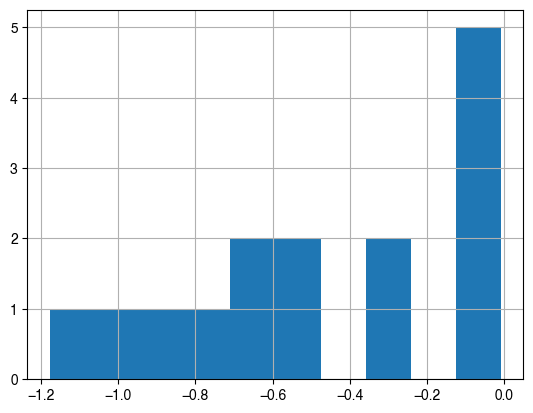

In [78]:
df[df.mutation.isin(very_major_errors)].deep_ddG.hist()

<AxesSubplot:>

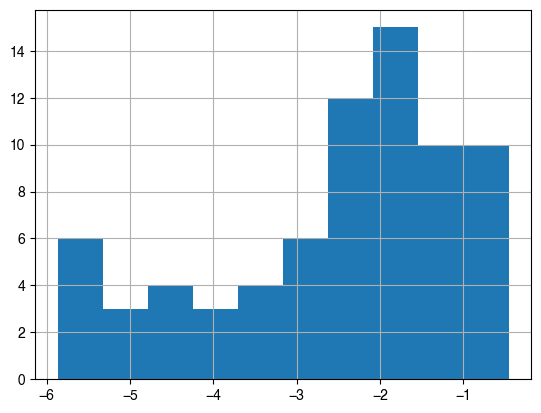

In [79]:
df[df.mutation.isin(correct_R)].deep_ddG.hist()

In [68]:
df

,mutation,segid,phenotype,d_volume,d_hydropathy_KD,d_Pi,d_MW,d_rogov,phi,psi,residue_sasa,n_hbond_acceptors,n_hbond_donors,secondary_structure_codes,temp_factor,depth,deep_ddG,rasp_wt_nlf,rasp_mt_nlf,rasp_score_ml_fermi,snap2_score,dist_FE2,dist_PZA,mcsm_stability_rsa,mcsm_stability_ddG,mapp_score
0,M1L,A,R,3.8,1.9,0.24,-18.0,-0.389,0.00,-35.20,86.2,2.0,0.0,4,59.720001,2.103049,-0.770,3.785957,2.433114,0.223921,20,29.948318,27.641663,54.8,-0.771,13.49
1,M1T,A,R,-46.8,-2.6,-0.14,-30.1,-0.548,0.00,-35.20,86.2,2.0,0.0,4,59.720001,2.103049,-1.096,3.785957,2.896883,0.281366,52,29.948318,27.641663,54.8,-0.367,25.97
2,M1V,A,S,-22.9,2.3,0.22,-32.1,-0.514,0.00,-35.20,86.2,2.0,0.0,4,59.720001,2.103049,-0.908,3.785957,2.623741,0.258386,4,29.948318,27.641663,54.8,-0.912,30.01
3,R2Q,A,S,-29.6,1.0,-5.11,-28.0,0.375,-117.94,133.99,54.7,2.0,0.0,0,53.990002,2.372958,-1.144,3.035567,3.338515,0.331465,-26,27.459823,24.722696,27.5,-0.790,2.68
4,A3E,A,R,49.8,-5.3,-2.78,58.0,-0.033,-126.53,153.85,0.0,1.0,1.0,0,43.310001,5.503930,-5.340,2.483982,2.712832,0.554393,56,24.149025,21.557456,0.0,-2.528,35.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,S185G,A,S,-28.9,0.4,0.29,-30.0,0.120,-73.76,0.00,67.6,0.0,0.0,4,53.709999,1.798143,-0.900,2.844502,2.560213,0.273806,69,27.305858,22.750537,12.8,-0.597,3.20
660,S185I,A,S,77.7,5.3,0.34,26.1,-0.026,-73.76,0.00,67.6,0.0,0.0,4,53.709999,1.798143,0.128,2.844502,2.854018,0.215031,62,27.305858,22.750537,12.8,-0.234,2.82
661,S185N,A,S,25.1,-2.7,-0.27,27.0,0.271,-73.76,0.00,67.6,0.0,0.0,4,53.709999,1.798143,-1.120,2.844502,3.127102,0.229262,53,27.305858,22.750537,12.8,-0.277,1.51
662,S185R,A,S,84.4,-3.7,5.08,69.1,0.127,-73.76,0.00,67.6,0.0,0.0,4,53.709999,1.798143,-0.811,2.844502,3.035567,0.274627,67,27.305858,22.750537,12.8,-0.124,2.78
